In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data_creation_final.csv')
logos = pd.read_csv('logos.csv')
logo_mapper = pd.read_csv('ncaa_name_mapper.csv')

In [3]:
data[data['Season'] == 2024].head()

,Season,Round,RegionTeamA,RegionTeamB,TeamA,TeamB,SeedTeamA,SeedTeamB,ScoreTeamA,ScoreTeamB,...,TeamB_AvgTotOppFTM,TeamB_AvgTotOppFTA,TeamB_AvgTotOppOR,TeamB_AvgTotOppDR,TeamB_AvgTotOppAst,TeamB_AvgTotOppTO,TeamB_AvgTotOppStl,TeamB_AvgTotOppBlk,TeamB_AvgTotOppPF,ResultTeamA
1315,2024,0.0,Y,Y,Colorado St,Virginia,10,10,67,42,...,10.3,13.7,7.9,23.9,11.2,11.2,5.1,3.2,13.0,1
1316,2024,0.0,Z,Z,Colorado,Boise St,10,10,60,53,...,13.1,18.2,6.4,21.7,11.5,10.6,5.7,3.9,17.3,1
1317,2024,0.0,X,X,Wagner,Howard,16,16,71,68,...,16.0,22.8,9.1,19.9,12.3,11.3,7.6,3.7,19.0,1
1318,2024,0.0,Y,Y,Grambling,Montana St,16,16,88,81,...,15.0,21.0,8.2,24.4,12.4,12.6,5.8,2.6,17.4,1
1319,2024,1.0,W,W,Connecticut,Stetson,1,16,91,52,...,11.6,15.8,9.4,22.2,13.8,8.5,6.1,2.7,16.8,1


In [4]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import sys

data = pd.read_csv('data_creation_final.csv')

# Load and preprocess data
data = data[data['Season'] != 2021].drop(columns=['ScoreTeamA', 'ScoreTeamB'])

train = data[data['Season'] < 2024].drop(columns=['Season'])
train_teams = train[['TeamA', 'TeamB']]
train_X = train.drop(columns=['RegionTeamA', 'RegionTeamB', 'TeamA', 'TeamB', 'ResultTeamA'])
train_Y = train['ResultTeamA']
test = data[data['Season'] == 2024].drop(columns=['Season'])

test_teams = test[['TeamA', 'TeamB']]
test_X = test.drop(columns=['RegionTeamA', 'RegionTeamB', 'TeamA', 'TeamB', 'ResultTeamA'])
test_Y = test['ResultTeamA']

model = LogisticRegression(max_iter=10000)
model.fit(train_X, train_Y)

# Full bracket simulating function
def simulate_tournament(test_data, model):
    
    custom_sort1 = ['W', 'X', 'Y', 'Z']
    custom_sort2 = [1, 16, 8, 9, 5, 12, 4, 13, 6, 11, 3, 14, 7, 10, 2, 15]
    
    region_order = {region: i for i, region in enumerate(custom_sort1)}
    seed_order = {seed: i for i, seed in enumerate(custom_sort2)}
    
    # These are the colnames that aren't prefixed by TeamA/TeamB but still may be
    # relevant predictors so I explicitly say them here
    # MAYBE THIS IS WHERE WE CAN ADD IN THEIR FEATURE ENGINEERED STUFF AS A FUNC ARG
    extra_cols_a = ['TotG', 'TotW', 'TotL', 'NeutralG', 'WinPct']
    extra_cols_b = ['TotG.1', 'TotW.1', 'TotL.1', 'NeutralG.1', 'WinPct.1']
    
    # Filter data to just R1
    # THIS IS USELESS IN THE FUTURE JUST DOING BC WE ARE TESTING ON DATA w/ FULL ROUND INFO!
    test_data = test_data[test_data['Round'] == 1]
    
    # Define R1 matchups
#     init_a = test_data[['TeamA', 'RegionTeamA', 'SeedTeamA']].tolist()
#     init_b = test_data[['TeamB', 'RegionTeamB', 'SeedTeamB']].tolist()
    
#     inits = []

    

    inits = list(test_data[['TeamA', 'RegionTeamA', 'SeedTeamA']].itertuples(index=False, name=None)) + \
            list(test_data[['TeamB', 'RegionTeamB', 'SeedTeamB']].itertuples(index=False, name=None))
    
    inits = sorted(inits, key=lambda x: (region_order[x[1]], seed_order[x[2]]))
    
#     for i in range(32):
#         inits.append(init_a[i])
#         inits.append(init_b[i])
    
    # Make our list of round by round preds to spit out
    to_return = []
    
    # Start with R1 (0 is first 4 which we dc about)
    current_round = 1
    
    # Run until we do the finals
    while current_round <= 6:
        # Filter to just current round
        round_data = test_data[test_data['Round'] == current_round]
        
        # If somehow no data, end
        if round_data.empty:
            break

        # Get our predictors and the teams by row
        round_X = round_data.drop(columns=['RegionTeamA', 'RegionTeamB', 'TeamA', 'TeamB', 'ResultTeamA'])
        round_teams = round_data[['TeamA', 'TeamB', 'RegionTeamA', 'RegionTeamB', 'SeedTeamA', 'SeedTeamB']]
                
        # Predict winners using the model you made
        predictions = model.predict(round_X)
            
        
        # Get the winner names
        winners = [(row.TeamA if pred == 1 else row.TeamB, row.RegionTeamA if pred == 1 else row.RegionTeamB, \
                    row.SeedTeamA if pred == 1 else row.SeedTeamB) for row, pred in zip(round_teams.itertuples(), predictions)]
        
        winners = sorted(winners, key=lambda x: (region_order[x[1]], seed_order[x[2]]))
        
        # Create new matchups for the next round
        next_round_data = []
        for i in range(0, len(winners), 2):
            if i + 1 < len(winners):
                next_team_A = winners[i][0]
                seed_team_A = winners[i][2]
                next_team_B = winners[i + 1][0]
                seed_team_B = winners[i + 1][2]
                
                # Get stats for each team
                team_A_stats = test_data[(test_data['TeamA'] == next_team_A) | (test_data['TeamB'] == next_team_A)].\
                    drop(columns=['TeamA', 'TeamB', 'ResultTeamA', 'SeedTeamA', 'SeedTeamB']).iloc[-1]
                team_B_stats = test_data[(test_data['TeamA'] == next_team_B) | (test_data['TeamB'] == next_team_B)].\
                    drop(columns=['TeamA', 'TeamB', 'ResultTeamA', 'SeedTeamA', 'SeedTeamB']).iloc[-1]

            
                # Get only relevant columns
                # WE MAY NEED TO CHANGE THIS BASED ON FEATURE SELECTION/ENGINEERING
                team_A_stats = team_A_stats[team_A_stats.index.str.contains('TeamA') | team_A_stats.index.isin(extra_cols_a)]
                team_B_stats = team_B_stats[team_B_stats.index.str.contains('TeamB') | team_B_stats.index.isin(extra_cols_b)]
                
                matchup = pd.concat([pd.Series({'TeamA': next_team_A, 'TeamB': next_team_B, \
                                      'Round': current_round + 1, 'SeedTeamA': seed_team_A, 'SeedTeamB': seed_team_B }), \
                                      team_A_stats, team_B_stats], axis=0)
                next_round_data.append(matchup)

                    
        # Convert the next round data to DF and append to our running new data
        test_data = pd.concat([test_data, pd.DataFrame(next_round_data)], ignore_index=True)
        
        # Add our rounds winners to our return var
        to_return.append(winners)
        
        # Move to next round
        current_round += 1

    # Add the teams from R1 (predefined by seeding) and return
    return [inits] + to_return

preds = simulate_tournament(test, model)

In [5]:
# Make pairwise matchups for plotting
plot_feeder = [[tuple(sublist[j:j+2]) if j+1 < len(sublist) else (sublist[j],) 
           for j in range(0, len(sublist), 2)] for sublist in preds]

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import string
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from urllib.request import urlopen
from fuzzywuzzy import process

def get_plot_params():
    # Define base recentangle params
    rect_width = 5
    rect_height = 1

    # Gap sizes for each rounds
    gaps = {16: rect_height/2, 8: rect_height*2, 4: rect_height*5, 2: rect_height*11, 1: rect_height*16}

    # Extra base height for each round
    y_off_add = {16: 0, 8: 0.75, 4: 2.25, 2: 5.25, 1: 11.25}
    
    return rect_width, rect_height, gaps, y_off_add

# Draw individual rectangle column (side of the bracket per round)
def draw_column(x_offset, preds, num_rectangles, ax, text_color='black'):
    
    rect_width, rect_height, gaps, y_off_add = get_plot_params()
    
    plt.rcParams.update({
        "font.family": "Arial",
    })
        
    if text_color == 'black':
        plt.rcParams.update({
            "lines.color": "black",
            "patch.edgecolor": "black",
            "text.color": text_color,
            "axes.facecolor": "white",
            "axes.edgecolor": "black",
            "axes.labelcolor": "black",
            "xtick.color": "black",
            "ytick.color": "black",
            "grid.color": "black",
            "figure.facecolor": "white",
            "figure.edgecolor": "white",
            "savefig.facecolor": "white",
            "savefig.edgecolor": "white"
        })
        face_color = 'white'
    else:
        plt.rcParams.update({
            "lines.color": "white",
            "patch.edgecolor": "white",
            "text.color": text_color,
            "axes.facecolor": "black",
            "axes.edgecolor": "white",
            "axes.labelcolor": "white",
            "xtick.color": "white",
            "ytick.color": "white",
            "grid.color": "white",
            "figure.facecolor": "black",
            "figure.edgecolor": "black",
            "savefig.facecolor": "black",
            "savefig.edgecolor": "black"
        })
        face_color = 'black'
    
    preds_copy = preds.copy()[::-1]
    for i in range(num_rectangles):
        gap = gaps[num_rectangles]
        y_offset = i * (rect_height + gap) + y_off_add[num_rectangles]
        
        # Add the rectangle to the plot to store matchup data
        rect = plt.Rectangle((x_offset, y_offset), rect_width, rect_height, edgecolor=text_color, facecolor=face_color)
        ax.add_patch(rect)
       
        # Left columns
        if x_offset < 0:
            # As long as not semis or later, draw connecting line to next round
            if num_rectangles > 1:
                ax.plot([x_offset, x_offset + 3*rect_width/2], [y_offset + rect_height / 2] * 2, color=text_color, linewidth=1)
            else:
                ax.plot([x_offset, x_offset + 2*rect_width], [y_offset + rect_height / 2] * 2, color=text_color, linewidth=1)
                
            # Direction of connecting "elbow" depends on if matchup is below or above middle line
            if i % 2 == 1 and num_rectangles > 1:
                ax.plot([x_offset + 3*rect_width/2] * 2, [y_offset + rect_height / 2, y_offset - gap/2 + rect_height/2], color=text_color, linewidth=1)
            elif i % 2 == 0 and num_rectangles > 1:
                ax.plot([x_offset + 3*rect_width/2] * 2, [y_offset + rect_height / 2, y_offset + gap/2 + rect_height/2], color=text_color, linewidth=1)
        
        # Right columns
        elif x_offset > 0:
            # As long as not semis or later, draw connecting line to next round
            if num_rectangles > 1:
                ax.plot([x_offset - rect_width/2, x_offset + rect_width], [y_offset + rect_height / 2] * 2, color=text_color, linewidth=1)
            else:
                ax.plot([x_offset - rect_width, x_offset + rect_width], [y_offset + rect_height / 2] * 2, color=text_color, linewidth=1)
            
            # Direction of connecting "elbow" depends on if matchup is below or above middle line
            if i % 2 == 1 and num_rectangles > 1:
                ax.plot([x_offset - rect_width/2] * 2, [y_offset + rect_height / 2, y_offset - gap/2 + rect_height/2], color=text_color, linewidth=1)
            elif i % 2 == 0 and num_rectangles > 1:
                ax.plot([x_offset - rect_width/2] * 2, [y_offset + rect_height / 2, y_offset + gap/2 + rect_height/2], color=text_color, linewidth=1)
        
        # Center (finals)
        else:
            ax.plot([x_offset, x_offset + rect_width], [y_offset + rect_height / 2] * 2, color=text_color, linewidth=1)
        
        team1_text = f"({preds_copy[i][0][2]}) {preds_copy[i][0][0]}"
        team1_short_name = preds_copy[i][0][0]
        
        font_sizes = {}
        
        team2_text = f"({preds_copy[i][1][2]}) {preds_copy[i][1][0]}"
        team2_short_name = preds_copy[i][1][0]
        
        desired_height = 9
        within_box_offset = 0.2
        img_left_offset = 0.5
        
        # Add team names (as long as > 1 team left)
        if len(preds_copy) > 0 and len(preds_copy[i]) > 1:
            
            team1_full_name = logo_mapper[logo_mapper['short_name'] == team1_short_name]['full_name'].iloc[0]
            team2_full_name = logo_mapper[logo_mapper['short_name'] == team2_short_name]['full_name'].iloc[0]

            team1_best_match = process.extractOne(team1_full_name, logos['Image Alt'])
            team2_best_match = process.extractOne(team2_full_name, logos['Image Alt'])
            
            if x_offset <= 0:
                
                ax.text(
                    x_offset + rect_width / 3, 
                    y_offset + (3/4) * rect_height, 
                    team1_text, 
                    fontsize=5 if len(team1_text) > 15 else (7.5 if len(team1_text) < 10 else 6), 
                    ha='left', 
                    va='center',
                    color=text_color
                )
                ax.text(
                    x_offset + rect_width / 3, 
                    y_offset + (1/4) * rect_height, 
                    team2_text, 
                    fontsize=5 if len(team2_text) > 15 else (7.5 if len(team2_text) < 10 else 6), 
                    ha='left', 
                    va='center',
                    color=text_color
                )
                
                img1 = Image.open(urlopen(logos[logos['Image Alt'] == team1_best_match[0]]['Image Src'].iloc[0].replace("80", "200")))
                img1 = np.array(img1)

                height, width, _ = img1.shape
                aspect_ratio = width / height

                # Calculate the corresponding width to maintain aspect ratio
                desired_width = desired_height * aspect_ratio

                # Create OffsetImage with the calculated size
                imagebox1 = OffsetImage(img1, zoom=desired_height / height)

                ab1 = AnnotationBbox(imagebox1, 
                                    (x_offset + img_left_offset, y_offset + rect_height - within_box_offset),
                                    frameon=False, 
                                    xycoords='data', 
                                    boxcoords="data")  # Adjust as needed for positioning
                ax.add_artist(ab1)

                img2 = Image.open(urlopen(logos[logos['Image Alt'] == team2_best_match[0]]['Image Src'].iloc[0].replace("80", "200")))
                img2 = np.array(img2)
                
                height, width, _ = img2.shape
                aspect_ratio = width / height

                # Calculate the corresponding width to maintain aspect ratio
                desired_width = desired_height * aspect_ratio

                # Create OffsetImage with the calculated size
                imagebox2 = OffsetImage(img2, zoom=desired_height / height)

                ab2 = AnnotationBbox(imagebox2, 
                                    (x_offset + img_left_offset, y_offset + within_box_offset),
                                    frameon=False, 
                                    xycoords='data', 
                                    boxcoords="data")  # Adjust as needed for positioning
                ax.add_artist(ab2)
            else:
                
                ax.text(
                    x_offset, 
                    y_offset + (3/4) * rect_height, 
                    team1_text, 
                    fontsize=5 if len(team1_text) > 15 else (7.5 if len(team1_text) < 10 else 6), 
                    ha='left', 
                    va='center',
                    color=text_color
                )
                ax.text(
                    x_offset, 
                    y_offset + (1/4) * rect_height, 
                    team2_text, 
                    fontsize=5 if len(team2_text) > 15 else (7.5 if len(team2_text) < 10 else 6), 
                    ha='left', 
                    va='center',
                    color=text_color
                )
                
                img1 = Image.open(urlopen(logos[logos['Image Alt'] == team1_best_match[0]]['Image Src'].iloc[0].replace("80", "200")))
                img1 = np.array(img1)

                height, width, _ = img1.shape
                aspect_ratio = width / height

                # Calculate the corresponding width to maintain aspect ratio
                desired_width = desired_height * aspect_ratio

                # Create OffsetImage with the calculated size
                imagebox1 = OffsetImage(img1, zoom=desired_height / height)


                ab1 = AnnotationBbox(imagebox1, 
                                    (x_offset + 4.25, y_offset + rect_height - within_box_offset),
                                    frameon=False, 
                                    xycoords='data', 
                                    boxcoords="data")  # Adjust as needed for positioning
                ax.add_artist(ab1)

                img2 = Image.open(urlopen(logos[logos['Image Alt'] == team2_best_match[0]]['Image Src'].iloc[0].replace("80", "200")))
                img2 = np.array(img2)
                
                height, width, _ = img2.shape
                aspect_ratio = width / height

                # Calculate the corresponding width to maintain aspect ratio
                desired_width = desired_height * aspect_ratio

                # Create OffsetImage with the calculated size
                imagebox2 = OffsetImage(img2, zoom=desired_height / height)

                ab2 = AnnotationBbox(imagebox2, 
                                    (x_offset + 4.25, y_offset + within_box_offset),
                                    frameon=False, 
                                    xycoords='data', 
                                    boxcoords="data")  # Adjust as needed for positioning
                ax.add_artist(ab2)

In [74]:
def draw_all_cols(name="My", text_color='black'):
    fig, ax = plt.subplots(figsize=(16, 9))
    
    plt.rcParams.update({
        "font.family": "Arial",
    })
    
    if text_color == 'black':
        plt.rcParams.update({
            "lines.color": "black",
            "patch.edgecolor": "black",
            "text.color": text_color,
            "axes.facecolor": "white",
            "axes.edgecolor": "black",
            "axes.labelcolor": "black",
            "xtick.color": "black",
            "ytick.color": "black",
            "grid.color": "black",
            "figure.facecolor": "white",
            "figure.edgecolor": "white",
            "savefig.facecolor": "white",
            "savefig.edgecolor": "white"
        })
    else:
        plt.rcParams.update({
        "lines.color": "white",
        "patch.edgecolor": "white",
        "text.color": text_color,
        "axes.facecolor": "black",
        "axes.edgecolor": "white",
        "axes.labelcolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "grid.color": "white",
        "figure.facecolor": "black",
        "figure.edgecolor": "black",
        "savefig.facecolor": "black",
        "savefig.edgecolor": "black"
    })

    dists = [-30, -25, -20, -15, -10, 0, 10, 15, 20, 25, 30]
    n_cols = [16, 8, 4, 2, 1, 1, 1, 2, 4, 8, 16]
    rounds = [0, 1, 2, 3, 4, 5, 4, 3, 2, 1, 0]

    for i in range(0, len(dists)):
        print(i)
        if i <= 5:
            draw_column(dists[i], plot_feeder[rounds[i]][:n_cols[i]], n_cols[i], ax, text_color)
        else:
            draw_column(dists[i], plot_feeder[rounds[i]][n_cols[i]:], n_cols[i], ax, text_color)
            
    _, rect_height_help, _, _ = get_plot_params()

    # Set axis limits and remove axes
    ax.set_xlim(-30, 35)
    
    # Hard coded based on initial params but we can change later if we need to
    ax.set_ylim(-1, 16 * (rect_height_help + 0.5))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    
    if name != "My":
        name += "'s"
    
    plt.title(f"{name} 2025 March Madness Bracket".upper())
    
    ax.text(2.5, 21, "My 2025 Champion", ha='center', weight='bold')
    
    champ_short_name = plot_feeder[-1][0][0][0]
    
    champ_full_name = logo_mapper[logo_mapper['short_name'] == champ_short_name]['full_name'].iloc[0]
    champ_best_match = process.extractOne(champ_full_name, logos['Image Alt'])
    
    champ = Image.open(urlopen(logos[logos['Image Alt'] == champ_best_match[0]]['Image Src'].iloc[0].replace("80", "200")))
    champ = np.array(champ)

    imagebox = OffsetImage(champ, zoom=0.7)


    ab = AnnotationBbox(imagebox, 
                        (2.5, 17),
                        frameon=False, 
                        xycoords='data', 
                        boxcoords="data")  # Adjust as needed for positioning
    ax.add_artist(ab)
    
    plt.savefig('myplot.png', bbox_inches='tight')
    plt.close() 

In [75]:
draw_all_cols('Jake')

0
1
2
3
4
5
6
7
8
9
10


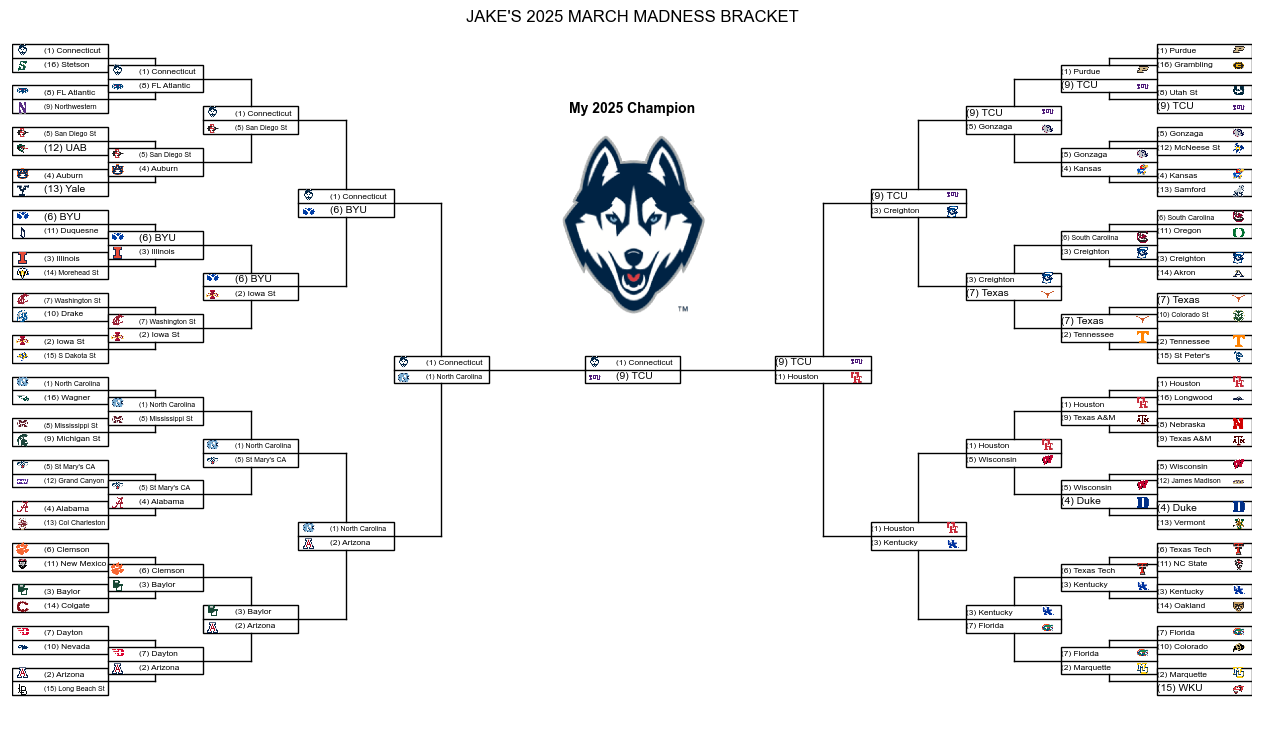

In [76]:
from IPython.display import Image as imshower
imshower(filename='myplot.png') 